In [1]:
#sparting spark and reading Reddit
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Reddit").getOrCreate()
df = None
df = spark.read.csv("s3a://andrew-bierbaum-insight-test-dataset/HackerNews/hacker_news_full-000*.csv.gz", header=True,multiLine=True, escape='"')

In [2]:
#spark.sql.caseSensitive = False
#sqlContext.sql("set spark.sql.caseSensitive=false")

In [3]:
#showing the start of the data and format
df.show(5)
df.printSchema()

+-------------+-----+----------+--------------------+-----+-------+----+--------------------+--------+-------+----+-----------+--------+-------+
|           by|score|      time|           timestamp|title|   type| url|                text|  parent|deleted|dead|descendants|      id|ranking|
+-------------+-----+----------+--------------------+-----+-------+----+--------------------+--------+-------+----+-----------+--------+-------+
|      jonpugh| null|1470011203|2016-08-01 00:26:...| null|comment|null|I still can&#x27;...|12198470|   null|null|       null|12199585|   null|
|mnemonicsloth| null|1283987630|2010-09-08 23:13:...| null|comment|null|<a href="http://y...| 1673082|   null|null|       null| 1673847|   null|
|         null| null|1464793231|2016-06-01 15:00:...| null|comment|null|                null|11812488|   true|null|       null|11814825|   null|
|  maxerickson| null|1493134717|2017-04-25 15:38:...| null|comment|null|First couple minu...|14194417|   null|null|       null|141

In [4]:
#Convert spark data to be readable using sql queries
df.createOrReplaceTempView("HackerNews")
xamarin_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%xamarin%'")
flutter_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%flutter%'")
#microsoft_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%microsoft%'")
#apple_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%apple%'")
#facebook_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%facebook%'")
#amazon_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%amazon%'")
#google_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%google%'")
#netflix_results = spark.sql("SELECT time, text FROM HackerNews WHERE text LIKE '%netlifx%'")
flutter_results.show()

+----------+--------------------+
|      time|                text|
+----------+--------------------+
|1479315901|Dart doesn&#x27;t...|
|1502483965|When I checked th...|
|1338561554|Palo Alto, CA (mo...|
|1476804427|I&#x27;ve had ove...|
|1366477991|Some people are s...|
|1517872188|As an alternative...|
|1543004026|The Flutter engin...|
|1408390700|For me the major ...|
|1464415718|Everyone is an em...|
|1546422588|... This is a goo...|
|1523553037|I actually don&#x...|
|1509216526|This is really ex...|
|1526137010|We have a new plu...|
|1528009047|This all sounds v...|
|1460752942|I&#x27;m trying o...|
|1543068603|One year and coun...|
|1543953359|There&#x27;s Flut...|
|1495951869|I also played wit...|
|1543948117|They previewed Pr...|
|1535082902|Used to do Androi...|
+----------+--------------------+
only showing top 20 rows



In [5]:
#collect, convert dates to datetime format for later graphing, and sort data
from datetime import datetime
python_xamarin_results = xamarin_results.collect()
python_xamarin_results_cleaned = [(datetime.fromtimestamp(float(i)),body.encode('ascii',errors='ignore')) for i, body in python_xamarin_results]
python_xamarin_results_cleaned.sort()


In [10]:
#repeat collect, convert dates to datetime format for later graphing, and sort data for flutter results
python_flutter_results = flutter_results.collect()
python_flutter_results_cleaned = [(datetime.fromtimestamp(float(i)),body.encode('ascii',errors='ignore')) for i, body in python_flutter_results]
python_flutter_results_cleaned.sort()

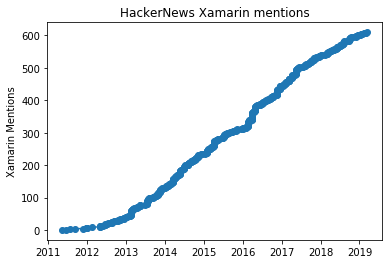

<Figure size 432x288 with 0 Axes>

In [7]:
#sort, number, and then graph the data
%matplotlib inline
import numpy
import matplotlib
import matplotlib.pyplot as plt
count = numpy.arange(len(python_xamarin_results_cleaned))
#Date_Data = matplotlib.dates.datestr2num(clean_python_results_utc)
Date_Data = []
Body_Data = []
for date, body in python_xamarin_results_cleaned:
    Date_Data.append(date)
    Body_Data.append(body)
matplotlib.pyplot.plot_date(Date_Data,count,xdate=True, drawstyle = 'steps-pre', linestyle = 'solid' )
matplotlib.pyplot.ylabel('Xamarin Mentions')
matplotlib.pyplot.title('HackerNews Xamarin mentions')
plt.show()
plt.savefig('HackerNews_xamarin.png')

In [8]:
import pandas
pandas_df = pandas.DataFrame({'date':Date_Data,'body':Body_Data})
pandas_df.head()
pandas_df.to_csv("HackerNews_xamarin.csv")

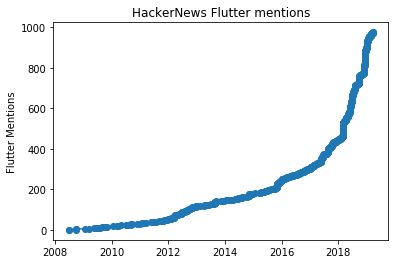

<Figure size 432x288 with 0 Axes>

In [11]:
#repeat graphing and later csv export for flutter
count = numpy.arange(len(python_flutter_results_cleaned))
Date_Data = []
Body_Data = []
for date, body in python_flutter_results_cleaned:
    Date_Data.append(date)
    Body_Data.append(body)
matplotlib.pyplot.plot_date(Date_Data,count,xdate=True, drawstyle = 'steps-pre', linestyle = 'solid' )
matplotlib.pyplot.ylabel('Flutter Mentions')
matplotlib.pyplot.title('HackerNews Flutter mentions')
plt.show()
plt.savefig('HackerNews_flutter.png')

#print csv for flutter
pandas_df = pandas.DataFrame({'date':Date_Data,'body':Body_Data})
pandas_df.head()
pandas_df.to_csv("HackerNews_flutter.csv")

In [14]:
#building dash graph
import dash
import dash_core_components as dcc
import dash_html_components as html

df = pandas.read_csv("HackerNews_xamarin.csv")
xamarin_Date_Data = df['date'].tolist()
xamarin_Body_Data = df['body'].tolist()
xamarin_count = df['Unnamed: 0'].tolist()
df = None

df = pandas.read_csv("HackerNews_flutter.csv")
flutter_Date_Data = df['date'].tolist()
flutter_Body_Data = df['body'].tolist()
flutter_count = df['Unnamed: 0'].tolist()
df = None

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

app = dash.Dash(__name__, external_stylesheets=external_stylesheets)

app.layout = html.Div(children=[
    html.H1(children='HackerNews Mentions'),
    html.Div(children='''Comparing the mentions of Xamarin and Flutter on HackerNews'''),
    
    #builds the year range selector
    dcc.RangeSlider(id='year_slider', min=2008, max=2020, value=[2008, 2020]),
                    
    #builds the graph                    
    dcc.Graph(
        id='HackerNews-graph',
        figure={
            'data': [
                {'x': xamarin_Date_Data, 'y': xamarin_count, 'text': xamarin_Body_Data,'type': 'scatter', 'name': 'HackerNews Xamarin Mentions'},
                {'x': flutter_Date_Data, 'y': flutter_count, 'text': flutter_Body_Data,'type': 'scatter', 'name': 'HackerNews Flutter Mentions'},
            ],
            'layout': {
                'title': 'Mentions'
            }
        }
    )
])
